# **프로젝트: 멋진 챗봇 만들기**

# **Step1. Import Necessary Libraries**

In [ ]:
# Mecab 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from konlpy.tag import Mecab
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import re
import random
import math
from tqdm import tqdm
from tqdm import tqdm_notebook
import gensim
from tensorflow.keras.preprocessing.sequence import pad_sequences

# **Step2. Import Data**
데이터는 https://github.com/songys/Chatbot_data 에서 ChatbotData .csv파일을 사용합니다.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/GoingDeeper_Data/GD6/ChatbotData.csv')
print(data.shape)
data.head()

(11823, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
questions = list(data.Q)
answers = list(data.A)
print('Q :',questions[:3])
print('A :',answers[:3])

Q : ['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다']
A : ['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.']


문장길이에 대한 분포를 확인해봅시다.

(array([1.200e+01, 7.300e+01, 4.100e+02, 9.200e+02, 1.648e+03, 1.673e+03,
        1.743e+03, 7.320e+02, 1.318e+03, 9.800e+02, 7.110e+02, 5.070e+02,
        3.340e+02, 1.950e+02, 1.330e+02, 7.700e+01, 1.080e+02, 6.100e+01,
        5.300e+01, 3.000e+01, 1.600e+01, 2.100e+01, 1.700e+01, 9.000e+00,
        7.000e+00, 8.000e+00, 7.000e+00, 5.000e+00, 3.000e+00, 4.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1.   ,  2.875,  4.75 ,  6.625,  8.5  , 10.375, 12.25 , 14.125,
        16.   , 17.875, 19.75 , 21.625, 23.5  , 25.375, 27.25 , 29.125,
        31.   , 32.875, 34.75 , 36.625, 38.5  , 40.375, 42.25 , 44.125,
        46.   , 47.875, 49.75 , 51.625, 53.5  , 55.375, 57.25 , 59.125,
        61.   , 62.875, 64.75 , 66.625, 68.5  , 70.375, 72.25 , 74.125,
        76.   ]),
 <a list of 40 Patch objects>)

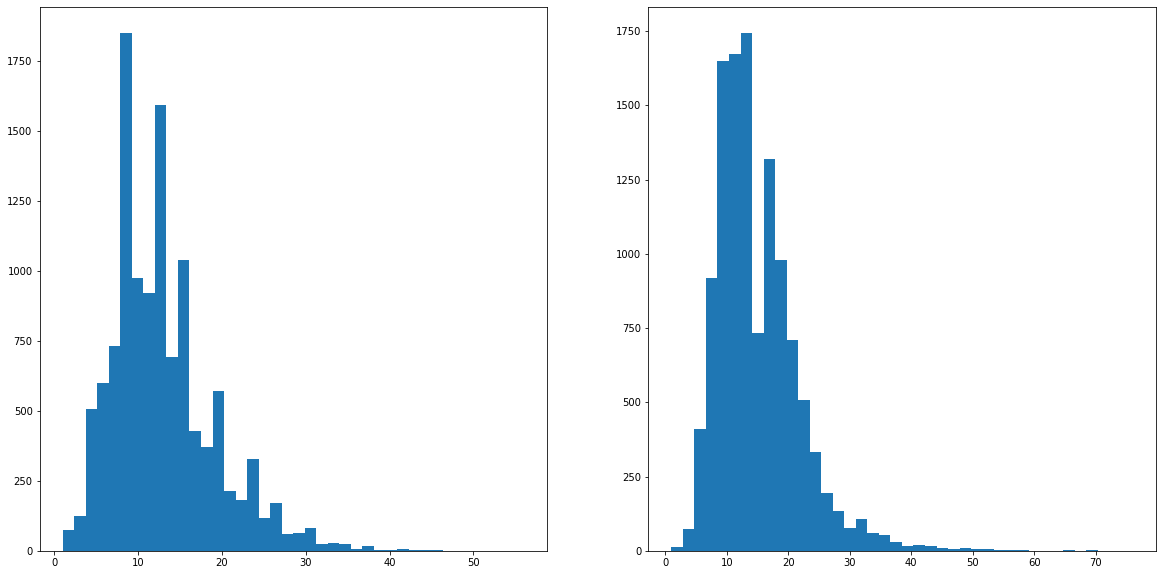

In [ ]:
len_q = []
len_a = []
for q, a in zip(questions, answers):
    len_q.append(len(q))
    len_a.append(len(a))

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].hist(len_q, bins=40)    
ax[1].hist(len_a, bins=40)

# **Step3. Preprocessing Data**

In [ ]:
# 전처리 함수 정의
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)

    return sentence

In [ ]:
# 데이터 토큰화
mecab = Mecab()
max_len = 30

def build_corpus(src, tgt):
    
    src_cor = []
    tgt_cor = []
    
    for s, t in zip(src, tgt):
        if len(s) <= max_len:
            src_cor.append(mecab.morphs(preprocess_sentence(s)))
            tgt_cor.append(mecab.morphs(preprocess_sentence(t)))
    
    
    return src_cor, tgt_cor

que_corpus, ans_corpus = build_corpus(questions, answers) 

# **Step4. Data Augmentation**
우리에게 주어진 데이터는 1만개 가량으로 적은편에 속합니다. 따라서 Lexical Substitution을 적용해 데이터를 늘려주도록하겠습니다. 아래 링크를 참고하여 한국어로 사전 훈련된 임베딩 모델을 다운로드합니다.
https://github.com/Kyubyong/wordvectors

해당 링크에서 Korean(w)를 찾아 다운로드하고, ko.bin파일을 이용합니다.

In [ ]:
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/GoingDeeper_Data/GD6/ko.bin')

불러온 모델은 아래와 같이 활용할 수 있습니다.

In [ ]:
model.most_similar("나비")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('호랑', 0.7221653461456299),
 ('거미', 0.7095274925231934),
 ('족제비', 0.6975173950195312),
 ('잠자리', 0.6971200108528137),
 ('네발', 0.6922956109046936),
 ('개구리', 0.6853677034378052),
 ('지렁이', 0.6686853170394897),
 ('캥거루', 0.6567738056182861),
 ('고슴도치', 0.6552319526672363),
 ('해파리', 0.6538781523704529)]

In [ ]:
# Lexical Substitution 구현하기
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]

    except: # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from :
            res += _to + " "
        else:
            res += tok + " "

    return res

해당함수를 한번 사용해볼까요?

In [ ]:
sentence = ['sns', '보', '면', '나', '만', '빼', '고', '다', '행복', '해', '보여']
lexical_sub(sentence, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


'sns 보 면 나 만 빼 고 으며 행복 해 보여 '

Augmentation된 que_corpus와 원본 ans_corpus가 병렬을 이루도록, 이후엔 반대로 원본que_corpus와 Augmentation된 ans_corpus가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

### **que_corpus Augmentation**

In [ ]:
new_que_corpus = []

for old_src in tqdm(que_corpus):
    new_src = lexical_sub(old_src, model)
    if new_src is not None:
        new_que_corpus.append(new_src)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다.
    else:
        new_que_corpus.append(old_src)
print()
print('Augmentation전 Q길이: ',len(que_corpus))
print('Augmentation후 Q길이: ',len(new_que_corpus))

  0%|          | 0/11650 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
100%|██████████| 11650/11650 [00:13<00:00, 874.48it/s]


Augmentation전 Q길이:  11650
Augmentation후 Q길이:  11650


### **ans_corpus Augmentation**

In [ ]:
new_ans_corpus = []

for old_src in tqdm(ans_corpus):
    new_src = lexical_sub(old_src, model)
    if new_src is not None:
        new_ans_corpus.append(new_src)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다.
    else:
        new_ans_corpus.append(old_src)
print()
print('Augmentation전 A길이: ',len(ans_corpus))
print('Augmentation후 A길이: ',len(new_ans_corpus))

  0%|          | 0/11650 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
100%|██████████| 11650/11650 [00:13<00:00, 864.51it/s]


Augmentation전 A길이:  11650
Augmentation후 A길이:  11650


어그멘테이션한 데이터들을 전부 합쳐줍시다.

In [ ]:
Augmented_que = que_corpus + new_que_corpus + que_corpus
print('Q길이 : ',len(Augmented_que))
Augmented_ans = ans_corpus + ans_corpus + new_ans_corpus
print('A길이 : ',len(Augmented_ans))

Q길이 :  34950
A길이 :  34950


이로써 데이터가 거의 3배가량 늘어났습니다.

# **Step5. 데이터 벡터화**
타겟 데이터인 ans_corpus에 \<start>토큰과 \<end>토큰이 추가되지 않은상태 이를 먼저 해결한후 벡터화를 진행합니다.

In [ ]:
change_ans = []

for ans in Augmented_ans:
    re_ans = ["<start>"] + list(ans) + ["<end>"]
    change_ans.append(re_ans)

change_ans[:3]

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'],
 ['<start>', '위로', '해', '드립니다', '.', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>']]

챗봇 훈련 데이터의 가장 큰 특징 중 하나는 바로 소스데이터와 타겟데이터가 같은 언어를 사용한다는 것입니다. 이는 임베딩 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

In [ ]:
# 질문,답변 말뭉치 병합
total_corpus = Augmented_que + change_ans
# 토크나이저 생성
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
# 사전 구축
tokenizer.fit_on_texts(total_corpus)
# 인코더 정수시퀀스 생성
enc_train = tokenizer.texts_to_sequences(Augmented_que)
enc_train = pad_sequences(enc_train, padding='post')
# 디코더 정수시퀀스 생성
dec_train = tokenizer.texts_to_sequences(change_ans)
dec_train = pad_sequences(dec_train, padding='post')

In [ ]:
# 사전 크기
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

7936

벡터화와 패딩이 잘 적용됐는지 확인해 봅시다.

In [ ]:
enc_train.shape

(34950, 21)

In [ ]:
enc_train[:2]

array([[2531,   68, 4380,  103,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 318, 3648,  619, 1063,   10,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [ ]:
dec_train[:2]

array([[   3,  327,    9,  163,    9,   56,    2,    4,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,  687,   13, 1822,    2,    4,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,

데이터는 준비가 다 되었습니다. 이제 트랜스포머 모델을 설계해 줍시다.

# **Step6. 모델설계**
## 1.Positional Encoding
어순에대한 정보가 들어있는 포지셔널 행렬을 생성해주는 함수입니다.

In [ ]:
def positional_encoding(pos, d_model):

    # pos/10000^(i/d_model)생성
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)
    
    # d_model열까지 cal_angle()함수값 계산
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    # 각 행(문장)마다 get_posi_angle_vec()함수 적용해서 넘파이 배열로 저장 
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    # 짝수 열(2i)에 해당하는 값만 sin()함수에 넣어서 테이블에 저장
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 홀수 열(2i+1)에 해당하는 값만 cos()함수에 넣어서 테이블에 저장
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    # 포지서널 인코딩 값이 계산된 행렬
    return sinusoid_table

## 2.Multi-Head Attention
어텐션을 병렬수행해주는 함수입니다.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // self.num_heads

        # Head로 쪼갠 Embedding들끼리 유사한 특성을 가진다는 보장이 없기 때문에 앞단에 Linear 레이어를 추가해 주는 겁니다.
        # Linear 레이어는 데이터를 특정 분포로 매핑 시키는 역할을 해주기 때문에, 설령 단어들의 분포가 제각각이더라도, 
        # Linear 레이어는 Multi-Head Attention이 잘 동작할 수 있는 적합한 공간으로 Embedding을 매핑합니다.
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        # 비슷한 이유로 각각의 Head가 Attention 한 값이 균일한 분포를 가질 거란 보장이 없습니다. 
        # 따라서 모든 Attention 값을 합쳐준 후, 최종적으로 Linear 레이어를 거치며 비로소 Multi-Head Attention이 마무리가 됩니다.
        self.linear = tf.keras.layers.Dense(d_model)

    # 임베딩벡터를 헤드수로 분할하는 함수
    # x : [batch x length x emb]
    # return : [batch x length x heads x self.depth]
    def split_heads(self, x):
        # 입력데이터 개수
        batch_size = x.shape[0]
        # 입력데이터 reshape
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # 입력데이터 차원의 1번과 2번인덱스 자리변경
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    # 분할된 입력으로부터 어텐션 값을 구하는 함수
    def scaled_dot_product_attention(self, Q, K, V, mask):
        # K의 길이를 실수형태로 d_k에 저장
        d_k = tf.cast(K.shape[-1], tf.float32)
        
        # Scaled QK 값 구하기
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)

        # 1. Attention Weights 값 구하기 -> attentions
        # 2. Attention 값을 V에 곱하기 -> out
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        return out, attentions

    # 분할된 Head를 다시 하나로 결합시켜주는 함수
    # x: [ batch x length x heads x self.depth ]
    # return: [ batch x length x emb ]
    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
    
    def call(self, Q, K, V, mask):

        # Step1 : Linear_in(Q, K, V) -> WQ, WK, WV
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        # Step2 : Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        # Step3 : scaled Dot Product Attention
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        # Step4 : combine Heads
        out = self.combine_heads(out)
        
        # Step5 : Linear_out
        out = self.linear(out)

        return out, attention_weights

## 3.Position-wise Feed_Forward Network
활성화함수 ReLU를 적용해주는 함수입니다.

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)

        return out

## 4.인코더 레이어

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        # Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        # Position-Wise Fedd Forward Network
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, enc_attn

## 5.디코더 레이어

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        # Multi-Head Attention
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

## 6.인코더

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        # 층수 설정
        self.n_layers = n_layers
        # 설정된 층수를 반복문으로 인코더계층 리스트생성
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]

    def call(self, x, mask):
        out = x
        enc_attns = list()
        
        # 각 계층별로 어텐션 가중치(확률분포)를 리스트에 저장 
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

## 7.디코더

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]

    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
        dec_attns = list()
        dec_enc_attns = list()

        # 각 계층별 두개의 어텐션 가중치(확률분포)를 각 리스트에 저장
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        return out, dec_attns, dec_enc_attns

## 8.트랜스포머
여기서 인코더와 디코더 각각의 임베딩과 출력층의 Linear계층, 총 3개의 레이어가 가중치를 공유합니다

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared_fc=True,
                 shared_emb=False):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            # 1.Embedding Layer 정의
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        # 2.Positional Encoding 정의
        self.pos_encoding = positional_encoding(pos_len, d_model)
        
        # 3.Dropout 정의
        self.dropout = tf.keras.layers.Dropout(dropout)

        # 4.인코더/디코더 정의
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        # 5.Output Linear 정의
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        # 6.Shared Weights
        self.shared_fc = shared_fc
        if shared_fc: 
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))
    
    def embedding(self, emb, x):
        # 문장길이 저장
        seq_len = x.shape[1]
        
        # 임베딩벡터 저장
        out = emb(x)
        
        # 1.가중치를 공유하는 두레이어의 feature분포가 다르기때문에, sqrt(d_model)을 곱해 분포를 맞춰주는과정
        # 2.포지셔널 인코딩이 임베딩벡터에 큰 영향을 끼치는것을 방지
        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        # 포지셔널인코딩과 임베딩벡터의 연산을 위해 차원을 변경시켜줌
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]

        # 드롭아웃적용
        out = self.dropout(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):

        # 1.Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        # 2.Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        # 3.Decoder(dec_in, enc_out, mask) -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        # 4.Out Linear(dec_out) -> logits
        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

## 9.마스킹

In [ ]:
# 패딩 마스킹 : 문장에서 패딩인 부분을 전부 찾아주는 함수
def generate_padding_mask(seq):
    # 문장에서 0인것을 전부 True, 아니면 False로 바꿔주고 이들을 전부 1과 0으로 표현
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # 문장형태에서 1과 2번인덱스에 차원추가
    return seq[:, tf.newaxis, tf.newaxis, :]

# 룩 어헤드 마스킹 : 마스크를 해줄요소가 전부1이고 아니면0인 행렬 생성
def generate_causality_mask(src_len, tgt_len):
    # np.eye(a, b) : a행b열의 단위행렬을 만들어줌
    # np.cumsum(a, axis=0) : 행을 그 다음행에 중첩하면서 더해줌, shape은 변하지않음
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

# 패딩 마스크와 룩 어헤드 마스크를 동시에 적용하는 함수
def generate_masks(src, tgt):
    # 입력과 타깃문장 패딩 마스킹 생성
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    # 인코더-디코더 어텐션 룩어헤드마스킹 생성
    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1]) 
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    # 디코더 어텐션 룩어헤드마스킹 생성
    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# **Step7. 훈련하기**
데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 
- Hyperparameters
    - n_layers: 1
    - d_model: 368
    - n_heads: 8
    - d_ff: 1024
    - dropout: 0.2

- Training Parameters
    - Warmup Steps: 1000
    - Batch Size: 64
    - Epoch At: 10

In [ ]:
# 모델인스턴스 생성
transformer = Transformer(
    n_layers=1,
    d_model=368,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=200,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)

d_model = 368

## 1.Learning Rate Schedular

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    # 학습률 스케줄러 수식에 해당하는 전개과정
    # 아래 과정으로 생선된 값을 learning rate로 사용
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = LearningRateScheduler(d_model=368)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

## 2.Loss function

In [ ]:
# logits : 텐서플로우에서 소프트맥스함수를 거치기전의 데이터
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # 마스킹되지 않은 입력의 개수로 Scaling하는 과정
    # 결론적으로 마스킹된부분의 loss는 계산하지않음
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # tf.reduce_sum() : 입력행렬내에서 설정된 axis를 기준으로 sum연산이 수행됨, 차원감소   
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## 3.Train_step

In [ ]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    # 시작토큰 제외
    gold = tgt[:, 1:]

    # 마스크행렬 생성
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])
        # tape.gradient() : 매스텝 학습이 진행될때마다 발생하는 그래디언트 추출
        gradients = tape.gradient(loss, model.trainable_variables)
    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
    # gradient가 업데이트 해야할 파라미터 지정
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

## 4.Train

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10


for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    np.random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                   dec_train[idx:idx+BATCH_SIZE],
                   transformer,
                   optimizer)
        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch 10: 100%|██████████| 547/547 [01:23<00:00,  6.52it/s, Loss 0.3152]


학습이 완료되었습니다. 이제 해당모델을 가지고, 문장을 생성해 봅시다.
## 5.문장생성함수

In [ ]:
# 정수시퀀스를 디코딩해주는함수
def get_decoded_sentence(sentence):
            return ' '.join([tokenizer.index_word[index] for index in sentence])

# 입력문장을 새로운문장으로 출력
def evaluate(sentence, model):

    sentence = preprocess_sentence(sentence)
    pieces = mecab.morphs(sentence)
    tokens = tokenizer.texts_to_sequences(pieces)
    _input = pad_sequences(tokens, maxlen=enc_train.shape[-1], padding='post')
    
    ids = [] 
    output = tf.expand_dims([3], 0) 
    
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
                
        # 예측 단어가 종료 토큰일 경우
        if 4 == predicted_id:
            result = get_decoded_sentence(ids)           
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        
        # word_to_index
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

def generate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)
    
    print('\nInput: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    return result

In [ ]:
generate("지루하다, 놀러가고 싶어.", transformer)


Input: 지루하다, 놀러가고 싶어.
Predicted translation: 마음 이 어디 든 좋 을 가 보 세요 .


In [ ]:
generate("오늘 일찍 일어났더니 피곤하다.", transformer)


Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 내일 은 더 나 을 수 있 을까요 .


In [ ]:
generate("간만에 여자친구랑 데이트 하기로 했어.", transformer)


Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 떨리 는 새 새 로 떨리 죠 .


In [ ]:
generate("집에 있는다는 소리야.", transformer)


Input: 집에 있는다는 소리야.
Predicted translation: 집   에   집   에   집   하   는   집   어 요   .  


질문과 답변에 어느정도 개연성이 보이지만, 문법이 조금 안맞네요.

# **Step8.성능 측정하기**
## 1.NLTK를 활용한 BLEU Score

In [51]:
reference = "많 은 자연어 처리 연구자 들 이 트랜스포머 를 선호 한다".split()
candidate = "적 은 자연어 학 개발자 들 가 트랜스포머 을 선호 한다 요".split()

print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: ['많', '은', '자연어', '처리', '연구자', '들', '이', '트랜스포머', '를', '선호', '한다']
번역문: ['적', '은', '자연어', '학', '개발자', '들', '가', '트랜스포머', '을', '선호', '한다', '요']
BLEU Score: 8.190757052088229e-155


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU score가 50점을 넘으면 정말 멋진 번역을 생성했다는 것입니다. 보통 목표치도 20~40점 정도이구요. 하지만 방금 나온 점수는 사실상 0점이라고 봐도 무방합니다. 왜 이렇게 낮은 점수가 나왔을까요?

In [52]:
print("1-gram:", sentence_bleu([reference], candidate, weights=[1, 0, 0, 0]))
print("2-gram:", sentence_bleu([reference], candidate, weights=[0, 1, 0, 0]))
print("3-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 1, 0]))
print("4-gram:", sentence_bleu([reference], candidate, weights=[0, 0, 0, 1]))

1-gram: 0.5
2-gram: 0.18181818181818182
3-gram: 2.2250738585072626e-308
4-gram: 2.2250738585072626e-308


바로 3-gram과 4-gram에서 거의 0점을 받았기 때문입니다. 
## 2.SmoothingFunction()으로 BLEU Score 보정하기
그래서 BLEU계산시 특정 N-gram이 0점이 나와서 너무 작아지는 문제를 보완하기 위해 SmoothingFunction()을 사용하고 있습니다. 이는 모든 Precision에 아주 작은 epsilon값을 더해주는 역할을 합니다.

In [53]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.5
BLEU-2: 0.18181818181818182
BLEU-3: 0.010000000000000004
BLEU-4: 0.011111111111111112

BLEU-Total: 0.05637560315259291


SmoothingFunction()으로 BLEU score를 보정한 결과, 무려 5점으로 올라갔습니다. 
## 3. 트랜스포머 모델의 번역 성능 알아보기
위 예시들을 이용해서 우리가 훈련한 모델이 얼마나 번역을 잘하는지 평가할 수 있습니다.

한 문장의 BLEU를 계산하는 calculate_bleu()을 만들어봅시다.

In [72]:
def calculate_bleu(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    # 타겟문장
    reference = tgt_sentence.split()
    # 예측문장 생성
    pieces, results, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(src_sentence, model)
    candidate = results.split()
    # bleu스코어 계산
    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score

해당 함수를 토대로 훈련데이터에있는 문장으로 BLEU스코어를 계산해 봅시다.

In [73]:
calculate_bleu(transformer, 
                 "3박4일 정도 놀러가고 싶다", 
                 "여행은 언제나 좋죠.", 
                 mecab, 
                 mecab)

Source Sentence:  3박4일 정도 놀러가고 싶다
Model Prediction:  ['잘', '해결', '되', '길', '바라', '요', '.']
Real:  ['여행은', '언제나', '좋죠.']
Score: 0.000000



0

In [74]:
calculate_bleu(transformer, 
                 "1지망 학교 떨어졌어", 
                 "위로해 드립니다.", 
                 mecab, 
                 mecab)		

Source Sentence:  1지망 학교 떨어졌어
Model Prediction:  ['잘', '되', '길', '바라', '요', '.']
Real:  ['위로해', '드립니다.']
Score: 0.000000



0

In [75]:
calculate_bleu(transformer, 
                 "SNS보면 나만 빼고 다 행복해보여", 
                 "자랑하는 자리니까요.", 
                 mecab, 
                 mecab)	

Source Sentence:  SNS보면 나만 빼고 다 행복해보여
Model Prediction:  ['sns', '흔적', '삭제', '하', '세요', '.']
Real:  ['자랑하는', '자리니까요.']
Score: 0.000000



0

두번째문장은 괜찮은 답변이긴하지만, 실제답변과 일치하지않아 0점이 나오네요.
# **회고**
- Data Augmentation을 진행할때 한국어로 사전 훈련된 임베딩 모델을 사용했는데, 딱히 맘에 들진 않았다. '나비'와 높은 유사도 순위가 '호랑, '거미', '족제비'라니...
- 그리고 Lexical Substitution을 진행할때 문장의 한개의 토큰만 대체를 했는데 한개가 아닌 2개,3개정도 어휘대체를하면 더 좋은 결과를 낼수 있을꺼같다.
- 처음 에포크를 돌렸을때 계속 오류가났었는데 입력데이터에 문제가있었다. 길이를 출력해보니까 인코더와 디코더입력데이터가 달랐다. 알고보니까, 인코더 인풋데이터를 어그멘테이션하기 전의 값을 사용한것이었다...그러니 당연히 shape이 맞지않으니 안돌아가는것이었다.
- 가장 많은 시간을 할애한 오류는 VOCAB_SIZE인거 같다..! 첫에포크를 돌릴때 계속해서 loss가 nan이 나왔다. 구글링해보았지만, 원하는 답변은 딱히 없었다. 결론은 트랜스포머 인스턴스를 생성할때 src_vocab_size와 tgt_vocab_size값이 너무 작아서였다. 모델 설계를 보면 해당 파라미터는 임베디 벡터의 행개수를 뜻한다. 내가 알고있는 이론으로는 임베딩벡터의 행은 단어사전의 수, 열은 임베딩차원(d_model, 임의값 설정)로 알고있었다. 그래서 단어사전수인 약7900정도의 값을 넣고 에폭을 돌리면 loss가 nan이 나온다. 그래서 이를 20000정도로 늘려서 해주니 정상적으로 돌아갔다...왜인지 도무지 이해가 안된다. 옆자리인 명님 말로는 단어사전크기를 7900으로하고 warm step을 낮추면 돌아간다고한다. 하지만 나도 warm_step을 낮춰봤지만 소용이 없었다. 뭐지..?
- BLEU스코어가 정말 챗봇의 성능을 측정할 수 있는지가 의문이다. 몇 문장은 질문에 대한 답변이 꽤 개연성있게 나왔다고 생각한다. 하지만 이를 실제 타겟문장과 비교해 BLEU score를 계산하니 당연히 0이 나왔다. 질문에 대한 답변이 정해져있다는것부터 별로인거같다.